<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Como ejemplo se utilizará como corpus un dataset canciones de bandas de habla inglés.

In [2]:
# !rm -rf /content/dataset

In [3]:
import os
import platform

dataset_dir = 'dataset'
os.makedirs(dataset_dir, exist_ok=True)

url_nietzsche = "https://raw.githubusercontent.com/ramafeichu/natural-language-processing/main/desafios/desafio-2/src/Friedrich_Nietzsche_-_Mas_Alla_del_Bien_y_del_Mal.txt"
url_platon = "https://raw.githubusercontent.com/ramafeichu/natural-language-processing/main/desafios/desafio-2/src/Platon_-_El_Banquete.txt"
url_sun_tzu = "https://raw.githubusercontent.com/ramafeichu/natural-language-processing/main/desafios/desafio-2/src/Sun_Tzu_-_El_Arte_de_la_Guerra.txt"

print("Archivos descargados en la carpeta 'dataset'")

if platform.system() == 'Windows':
    os.system(f"curl -o {dataset_dir}/nietzsche.txt \"{url_nietzsche}\"")
    os.system(f"curl -o {dataset_dir}/platon.txt \"{url_platon}\"")
    os.system(f"curl -o {dataset_dir}/sun_tzu.txt \"{url_sun_tzu}\"")
else:
    os.system(f"wget -P {dataset_dir}/ \"{url_nietzsche}\"")
    os.system(f"wget -P {dataset_dir}/ \"{url_platon}\"")
    os.system(f"wget -P {dataset_dir}/ \"{url_sun_tzu}\"")

Archivos descargados en la carpeta 'dataset'


In [4]:
# Posibles bandas
os.listdir("./dataset/")

['Sun_Tzu_-_El_Arte_de_la_Guerra.txt',
 'Friedrich_Nietzsche_-_Mas_Alla_del_Bien_y_del_Mal.txt',
 'Platon_-_El_Banquete.txt']

In [5]:
ruta = "./dataset/"
archivos = os.listdir("./dataset/")


dfs = []

for archivo in archivos:
    df_temp = pd.read_csv(os.path.join(ruta, archivo), sep='/n', header=None, names=["Texto"], encoding="latin")

    # Separo por punto también
    df_temp = df_temp["Texto"].str.split(r"\.", expand=True).stack().reset_index(drop=True).to_frame()

    df_temp["Fuente"] = archivo
    dfs.append(df_temp)

# Uno todo
df_final = pd.concat(dfs, ignore_index=True)

df_final.rename(columns={0: "Oración"}, inplace=True)

df_final.head()

<ipython-input-5-169964d14922>:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_temp = pd.read_csv(os.path.join(ruta, archivo), sep='/n', header=None, names=["Texto"], encoding="latin")
<ipython-input-5-169964d14922>:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_temp = pd.read_csv(os.path.join(ruta, archivo), sep='/n', header=None, names=["Texto"], encoding="latin")
<ipython-input-5-169964d14922>:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid thi

,Oración,Fuente
0,El Arte de la Guerra,Sun_Tzu_-_El_Arte_de_la_Guerra.txt
1,Sun Tzu,Sun_Tzu_-_El_Arte_de_la_Guerra.txt
2,Capítulo 1,Sun_Tzu_-_El_Arte_de_la_Guerra.txt
3,Sobre la evaluación,Sun_Tzu_-_El_Arte_de_la_Guerra.txt
4,Sun Tzu dice: la guerra es de vital importanci...,Sun_Tzu_-_El_Arte_de_la_Guerra.txt


In [6]:
print("Cantidad de documentos:", df_final.shape[0])

Cantidad de documentos: 4408


In [7]:
df_final = df_final[df_final['Oración'] != ""]
df_final

,Oración,Fuente
0,El Arte de la Guerra,Sun_Tzu_-_El_Arte_de_la_Guerra.txt
1,Sun Tzu,Sun_Tzu_-_El_Arte_de_la_Guerra.txt
2,Capítulo 1,Sun_Tzu_-_El_Arte_de_la_Guerra.txt
3,Sobre la evaluación,Sun_Tzu_-_El_Arte_de_la_Guerra.txt
4,Sun Tzu dice: la guerra es de vital importanci...,Sun_Tzu_-_El_Arte_de_la_Guerra.txt
...,...,...
4401,) fue un filósofo griego seguidor de Sócrates ...,Platon_-_El_Banquete.txt
4402,"En 387 fundó la Academia, institución que con...",Platon_-_El_Banquete.txt
4403,Platón participó activamente en la enseñanza ...,Platon_-_El_Banquete.txt
4404,"ética, psicología, antropología filosófica, ep...",Platon_-_El_Banquete.txt


In [8]:
df_final = df_final[df_final["Oración"].str.split().str.len() >= 3]
df_final

,Oración,Fuente
0,El Arte de la Guerra,Sun_Tzu_-_El_Arte_de_la_Guerra.txt
3,Sobre la evaluación,Sun_Tzu_-_El_Arte_de_la_Guerra.txt
4,Sun Tzu dice: la guerra es de vital importanci...,Sun_Tzu_-_El_Arte_de_la_Guerra.txt
5,No reflexionar seriamente sobre todo lo que l...,Sun_Tzu_-_El_Arte_de_la_Guerra.txt
7,Hay que valorarla en términos de cinco factore...,Sun_Tzu_-_El_Arte_de_la_Guerra.txt
...,...,...
4401,) fue un filósofo griego seguidor de Sócrates ...,Platon_-_El_Banquete.txt
4402,"En 387 fundó la Academia, institución que con...",Platon_-_El_Banquete.txt
4403,Platón participó activamente en la enseñanza ...,Platon_-_El_Banquete.txt
4404,"ética, psicología, antropología filosófica, ep...",Platon_-_El_Banquete.txt


### Elegir el tamaño del contexto

In [9]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [10]:
# cada verso lo guardamos en una lista
text = list(df_final.loc[:, 'Oración'])

In [11]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [12]:
text[0]

'El Arte de la Guerra'

In [13]:
segmented_sentences[0]

['el', 'arte', 'de', 'la', 'guerra']

In [14]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([1.426e+03, 8.860e+02, 4.090e+02, 2.140e+02, 9.900e+01, 5.900e+01,
        3.000e+01, 2.200e+01, 1.200e+01, 3.000e+00, 6.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([  2.  ,  21.15,  40.3 ,  59.45,  78.6 ,  97.75, 116.9 , 136.05,
        155.2 , 174.35, 193.5 , 212.65, 231.8 , 250.95, 270.1 , 289.25,
        308.4 , 327.55, 346.7 , 365.85, 385.  ]),
 <BarContainer object of 20 artists>)

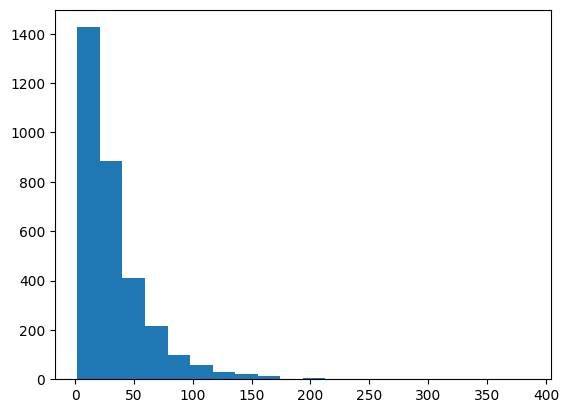

In [15]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [16]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 68


###  Tokenizar

In [17]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [18]:
tokenized_sentences[0]

[7, 144, 1, 4, 329]

In [19]:
segmented_sentences[0]

['el', 'arte', 'de', 'la', 'guerra']

### Organizando y estructurando el dataset

In [20]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

In [21]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size + 1):
    extra = len(sent) - (max_context_size + 1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i + max_context_size + 1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [22]:
len(tok_sent)

11995

In [23]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [24]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [25]:
train_seqs.shape

(717421, 69)

In [26]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

In [27]:
y.shape

(717421, 68)

In [28]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'que',
 3: 'y',
 4: 'la',
 5: 'en',
 6: 'a',
 7: 'el',
 8: 'los',
 9: 'no',
 10: 'se',
 11: 'es',
 12: 'un',
 13: 'una',
 14: 'lo',
 15: 'más',
 16: 'por',
 17: 'su',
 18: 'las',
 19: 'del',
 20: 'con',
 21: 'como',
 22: 'para',
 23: 'al',
 24: 'si',
 25: 'todo',
 26: 'ha',
 27: 'o',
 28: 'cuando',
 29: 'sus',
 30: 'ser',
 31: 'pero',
 32: 'hombre',
 33: 'son',
 34: 'sí',
 35: 'mismo',
 36: 'también',
 37: 'amor',
 38: 'le',
 39: 'esto',
 40: 'sobre',
 41: 'me',
 42: 'hasta',
 43: 'sin',
 44: 'nosotros',
 45: 'todos',
 46: 'hay',
 47: 'hombres',
 48: 'bien',
 49: 'él',
 50: 'entre',
 51: 'porque',
 52: 'ni',
 53: 'ya',
 54: 'así',
 55: 'tiene',
 56: 'vez',
 57: 'ellos',
 58: 'ese',
 59: 'toda',
 60: 'algo',
 61: 'cosas',
 62: 'sólo',
 63: 'ahora',
 64: 'cual',
 65: 'este',
 66: 'tan',
 67: 'nos',
 68: 'manera',
 69: 'yo',
 70: 'está',
 71: 'qué',
 72: 'pues',
 73: 'modo',
 74: 'incluso',
 75: 'voluntad',
 76: 'siempre',
 77: 'puede',
 78: 'moral',
 79: 'decir',
 80: 'sócr

In [29]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

13225

In [30]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'de': 1, 'que': 2, 'y': 3, 'la': 4, 'en': 5, 'a': 6, 'el': 7, 'los': 8, 'no': 9, 'se': 10, 'es': 11, 'un': 12, 'una': 13, 'lo': 14, 'más': 15, 'por': 16, 'su': 17, 'las': 18, 'del': 19, 'con': 20, 'como': 21, 'para': 22, 'al': 23, 'si': 24, 'todo': 25, 'ha': 26, 'o': 27, 'cuando': 28, 'sus': 29, 'ser': 30, 'pero': 31, 'hombre': 32, 'son': 33, 'sí': 34, 'mismo': 35, 'también': 36, 'amor': 37, 'le': 38, 'esto': 39, 'sobre': 40, 'me': 41, 'hasta': 42, 'sin': 43, 'nosotros': 44, 'todos': 45, 'hay': 46, 'hombres': 47, 'bien': 48, 'él': 49, 'entre': 50, 'porque': 51, 'ni': 52, 'ya': 53, 'así': 54, 'tiene': 55, 'vez': 56, 'ellos': 57, 'ese': 58, 'toda': 59, 'algo': 60, 'cosas': 61, 'sólo': 62, 'ahora': 63, 'cual': 64, 'este': 65, 'tan': 66, 'nos': 67, 'manera': 68, 'yo': 69, 'está': 70, 'qué': 71, 'pues': 72, 'modo': 73, 'incluso': 74, 'voluntad': 75, 'siempre': 76, 'puede': 77, 'moral': 78, 'decir': 79, 'sócrates': 80, 'esa': 81, 'contra': 82, 'vida': 83, 'muy': 84, 'tal': 85, 'sea': 86, 'o

In [31]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'arte': 72, 'de': 2070, 'el': 1422, 'guerra': 32, 'la': 1614, 'evaluación': 2, 'sobre': 203, 'tzu': 15, 'supervivencia': 2, 'imperio': 8, 'es': 1057, 'vital': 6, 'muerte': 18, 'o': 261, 'estado': 39, 'manejarla': 1, 'forzoso': 1, 'pérdida': 4, 'camino': 32, 'dice': 53, 'para': 545, 'importancia': 5, 'dominio': 26, 'sun': 17, 'vida': 104, 'bien': 179, 'hacia': 73, 'del': 627, 'todo': 319, 'querido': 24, 'prueba': 18, 'entre': 171, 'nosotros': 159, 'ocurrir': 8, 'seriamente': 1, 'a': 1422, 'en': 1468, 'no': 1030, 'conservación': 5, 'dar': 29, 'respecta': 7, 'y': 1778, 'culpable': 1, 'lo': 748, 'mas': 25, 'una': 759, 'concierne': 4, 'indiferencia': 6, 'que': 1886, 'reflexionar': 6, 'nos': 131, 'debe': 55, 'ello': 80, 'le': 214, 'factores': 9, 'vistas': 5, 'resultado': 12, 'diversas': 5, 'comparaciones': 4, 'rivales': 3, 'los': 1123, 'términos': 7, 'valorarla': 1, 'hacer': 94, 'determinar': 4, 'fundamentales': 5, 'cinco': 13, 'hay': 188, 'condiciones': 24, 'con'


### Definir el modelo

In [32]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 50)       │       661,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 100)      │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 100)      │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 13226)    │     1,335,826 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,137,926 (8.16 MB)

 Trainable params: 2,137,926 (8.16 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [34]:
hist = model.fit(X, y, epochs=5, batch_size=64)

Epoch 1/5
11210/11210 ━━━━━━━━━━━━━━━━━━━━ 510s 45ms/step - loss: 3.2877
Epoch 2/5
11210/11210 ━━━━━━━━━━━━━━━━━━━━ 510s 45ms/step - loss: 2.4307
Epoch 3/5
11210/11210 ━━━━━━━━━━━━━━━━━━━━ 509s 45ms/step - loss: 1.9624
Epoch 4/5
11210/11210 ━━━━━━━━━━━━━━━━━━━━ 566s 46ms/step - loss: 1.5312
Epoch 5/5
11210/11210 ━━━━━━━━━━━━━━━━━━━━ 560s 46ms/step - loss: 1.1624



### Predicción de próxima palabra

### Generación de secuencias

In [38]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [41]:
input_text='Me gustaría tener un'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


'Me gustaría tener un nuevo más profundo de eterna de ese prejuicio agradecidos a'

###  Beam search y muestreo aleatorio

In [42]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [43]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [45]:
# predicción con beam search.
# Se pueden cambiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="when i find myself in times",temp=1,mode='sto')

In [46]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 74)

In [47]:
# veamos las salidas
decode(salidas[0])

['i in servicios le sin el pintor en']

Pruebo ahora un modelo GRU

In [48]:
from keras.layers import GRU

model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))
model.add(GRU(100, return_sequences=True))
model.add(GRU(100, return_sequences=True))
model.add(Dense(vocab_size+1, activation='softmax'))

model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, None, 50)       │       661,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 100)      │        45,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, None, 100)      │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 13226)    │     1,335,826 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,103,326 (8.02 MB)

 Trainable params: 2,103,326 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
hist2 = model.fit(X, y, epochs=5, batch_size=64)

Epoch 1/5
11210/11210 ━━━━━━━━━━━━━━━━━━━━ 505s 45ms/step - loss: 3.0362
Epoch 2/5
11210/11210 ━━━━━━━━━━━━━━━━━━━━ 502s 45ms/step - loss: 2.0207
Epoch 3/5
11210/11210 ━━━━━━━━━━━━━━━━━━━━ 501s 45ms/step - loss: 1.5277
Epoch 4/5
11210/11210 ━━━━━━━━━━━━━━━━━━━━ 501s 45ms/step - loss: 1.2149
Epoch 5/5
11210/11210 ━━━━━━━━━━━━━━━━━━━━ 499s 45ms/step - loss: 1.0115


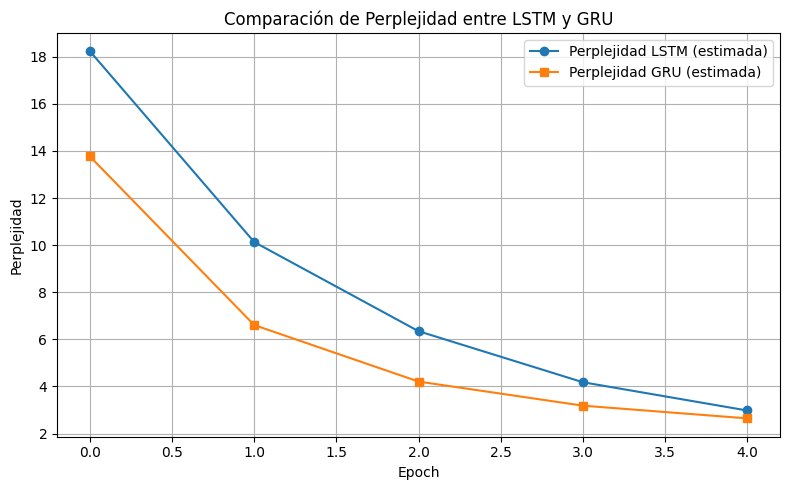

In [52]:
perplexity_lstm = np.exp(hist.history['loss'])
perplexity_gru = np.exp(hist2.history['loss'])

plt.figure(figsize=(8, 5))
plt.plot(perplexity_lstm, label='Perplejidad LSTM (estimada)', marker='o')
plt.plot(perplexity_gru, label='Perplejidad GRU (estimada)', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Perplejidad")
plt.title("Comparación de Perplejidad entre LSTM y GRU")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


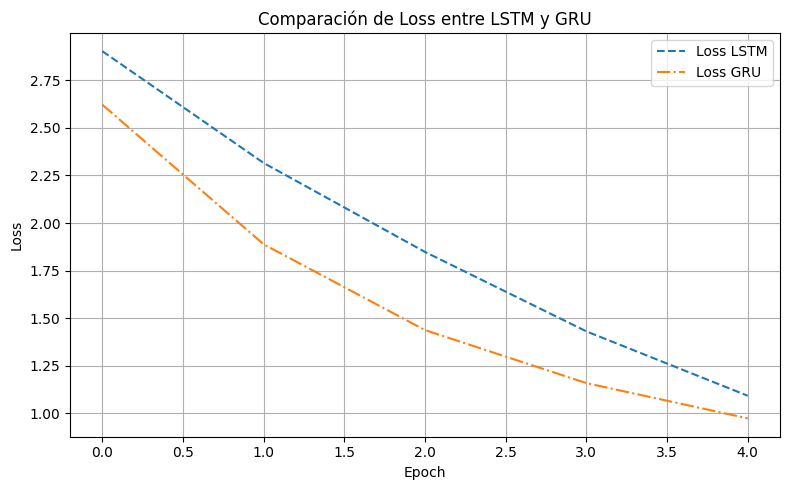

In [53]:
plt.figure(figsize=(8, 5))
plt.plot(hist.history['loss'], label='Loss LSTM', linestyle='--')
plt.plot(hist2.history['loss'], label='Loss GRU', linestyle='-.')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Comparación de Loss entre LSTM y GRU")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


He comparado el modelo inicial propuesto por la cátedra con un GRU solamente por cuestiones de tiempo (la entrega la estoy realizando pasada la primer oportunidad, y Colab o cierra la sesión o me quita el GPU cuando el entrenamiento es extenso). Si bien los resultados no son buenos, se puede verificar que por ser el GRU un modelo más simple (menos complejo, con menor cantidad de parámetros), los entrenamientos son más rápidos e inicialmente mejores. Probablemente, de utilizar un dataset lo suficientemente grande y abarcativo así como una cantidad determinante de epochs, el LSTM tendría mejores resultados.